In [1]:
from IPython.display import display
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from settings import docs_path

from datetime import date

from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import shap

In [2]:
sns.set(style="whitegrid")

# Análise Exploratória

### Obtenção da base de dados

In [3]:
data = pd.read_csv(os.path.join(docs_path, 'data.csv'))

### Visualização da base de dados

In [4]:
display(data)

,matchId,participants,endOfGameResult,timePlayed,gameVersion,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,...,100_JUNGLE,100_MIDDLE,100_TOP,100_UTILITY,200_BOTTOM,200_JUNGLE,200_MIDDLE,200_TOP,200_UTILITY,gameStartDate
0,BR1_3010891752,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,2249.354,14.20.623.6777,0,0,1.728968e+09,True,1,...,Vi,Malzahar,Darius,Seraphine,Smolder,Skarner,Taliyah,Yone,Pyke,2024-10-15
1,BR1_3010900586,"[""t1MptRkCqbuZLIerEjiY2-HUa3jBtMlCWBNdpMlUxSkV...",GameComplete,1830.368,14.20.623.6777,0,0,1.728971e+09,True,1,...,Nocturne,Ahri,Volibear,Seraphine,Ashe,FiddleSticks,Anivia,Tryndamere,Sylas,2024-10-15
2,BR1_3010910689,"[""RtPADu3TOFINdvaaLKYtoO4Kcmt4Rd4MIERMkCaUTYbe...",GameComplete,1829.868,14.20.623.6777,0,0,1.728978e+09,True,2,...,Nunu,Kalista,Camille,Thresh,Ashe,JarvanIV,Kassadin,Urgot,Seraphine,2024-10-15
3,BR1_3010910840,"[""gP_dHfHa4JNW05lseUFfvj-WzOtxuroeRAAnynflaAbR...",GameComplete,1449.219,14.20.623.6777,0,0,1.728979e+09,True,1,...,Talon,Vex,Irelia,Pyke,Smolder,Khazix,Yone,Jax,Zoe,2024-10-15
4,BR1_3010911395,"[""bJK3WphZHqsA6li6BhcivfO0vGRsgV_mMJDUhvmeFOce...",GameComplete,1596.042,14.20.623.6777,0,0,1.728976e+09,True,1,...,Qiyana,Ryze,KSante,Janna,Jinx,Karthus,Annie,TahmKench,Lulu,2024-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19729,BR1_3045138141,"[""BetEIxrtAIlInNcpH5zk2oKYrpG5eyP34cJg6q7LiVYf...",GameComplete,935.708,14.24.644.2327,1,0,1.735328e+09,True,0,...,Graves,Irelia,Aurora,Poppy,Karthus,FiddleSticks,Riven,Yone,Ashe,2024-12-27
19730,BR1_3045142382,"[""PytDMbfTsWLh2XHFtSiy752dRlHTBbBOBbRBP8X_meOK...",GameComplete,1164.522,14.24.644.2327,1,0,1.735329e+09,False,0,...,Rengar,Karthus,Gnar,Lulu,Varus,Zed,Malzahar,Jax,Nautilus,2024-12-27
19731,BR1_3045147939,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,1136.510,14.24.644.2327,1,0,1.735330e+09,True,0,...,FiddleSticks,Yasuo,Yone,Pyke,Jinx,Khazix,Irelia,Rumble,TahmKench,2024-12-27
19732,BR1_3045159983,"[""eamCq4fpOIwlJSenO93uikhfiI05vRWHjKSaeO-jn7xr...",GameComplete,100.717,14.24.644.2327,0,1,1.735332e+09,False,0,...,Ekko,Zed,Yasuo,TahmKench,Ezreal,Skarner,Irelia,Gragas,Leona,2024-12-27


### Verificação dos tipos das variáveis

In [5]:
dtypes_data = pd.DataFrame(data.dtypes)
print(dtypes_data)

                       0
matchId           object
participants      object
endOfGameResult   object
timePlayed       float64
gameVersion       object
...                  ...
200_JUNGLE        object
200_MIDDLE        object
200_TOP           object
200_UTILITY       object
gameStartDate     object

[102 rows x 1 columns]


In [6]:
data['win'] = data['win'].astype(int)

### Análise de Unicidade e Missings

In [7]:
print(f"Nº de registros duplicados:\n{data.duplicated(subset = 'matchId').sum()}\n")

print(f"Quantidade de valores nulos por colunas:\n{data.isnull().sum()}")

Nº de registros duplicados:
0

Quantidade de valores nulos por colunas:
matchId            0
participants       0
endOfGameResult    0
timePlayed         0
gameVersion        0
                  ..
200_JUNGLE         0
200_MIDDLE         0
200_TOP            0
200_UTILITY        0
gameStartDate      0
Length: 102, dtype: int64


### Análise Univariada

In [8]:
data.describe()

,timePlayed,gameEndedInSurrender,gameEndedInEarlySurrender,gameStartTimestamp,win,blue_side_baronKills,red_side_baronKills,blue_side_dragonKills,red_side_dragonKills,blue_side_riftHeraldKills,...,blue_side_total_neutral_minions_killed,red_side_total_neutral_minions_killed,blue_side_total_time_spent_dead,red_side_total_time_spent_dead,blue_side_total_detector_wards_placed,red_side_total_detector_wards_placed,blue_side_total_vision_wards_bought_in_game,red_side_total_vision_wards_bought_in_game,blue_side_total_wards_placed,red_side_total_wards_placed
count,19734.000000,19734.000000,19734.000000,1.973400e+04,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,...,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000,19734.000000
mean,1574.132719,0.307895,0.021384,1.730932e+09,0.526452,0.461538,0.465542,1.429462,1.743590,0.499949,...,116.664184,116.670569,739.498784,756.592277,11.781899,11.763099,13.431083,13.439951,60.203608,60.007550
std,452.618432,0.461635,0.144666,1.371868e+06,0.499312,0.634580,0.648473,1.198939,1.291745,0.500013,...,39.387899,40.071118,420.055956,409.258762,6.761074,6.847306,7.432521,7.534244,23.714479,23.963853
min,100.016000,0.000000,0.000000,1.728968e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1337.901250,0.000000,0.000000,1.729963e+09,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,92.000000,91.000000,413.000000,452.000000,7.000000,7.000000,8.000000,8.000000,45.000000,44.000000
50%,1606.361500,0.000000,0.000000,1.730749e+09,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,117.000000,116.000000,719.000000,738.000000,11.000000,11.000000,12.000000,12.000000,59.000000,59.000000
75%,1861.019500,1.000000,0.000000,1.731559e+09,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,...,142.000000,143.000000,1016.000000,1024.000000,16.000000,16.000000,18.000000,18.000000,74.000000,74.000000
max,3648.269000,1.000000,1.000000,1.735332e+09,1.000000,4.000000,4.000000,6.000000,6.000000,1.000000,...,399.000000,326.000000,3076.000000,2927.000000,57.000000,57.000000,63.000000,60.000000,199.000000,217.000000


#### Distribuição das Variáveis

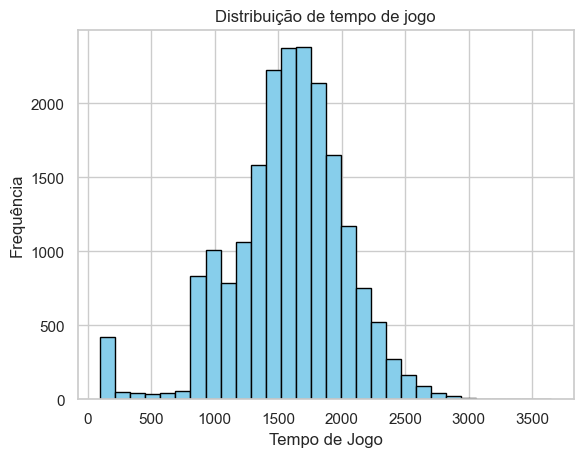

In [9]:
data['timePlayed'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição de tempo de jogo')
plt.xlabel('Tempo de Jogo')
plt.ylabel('Frequência')
plt.show()

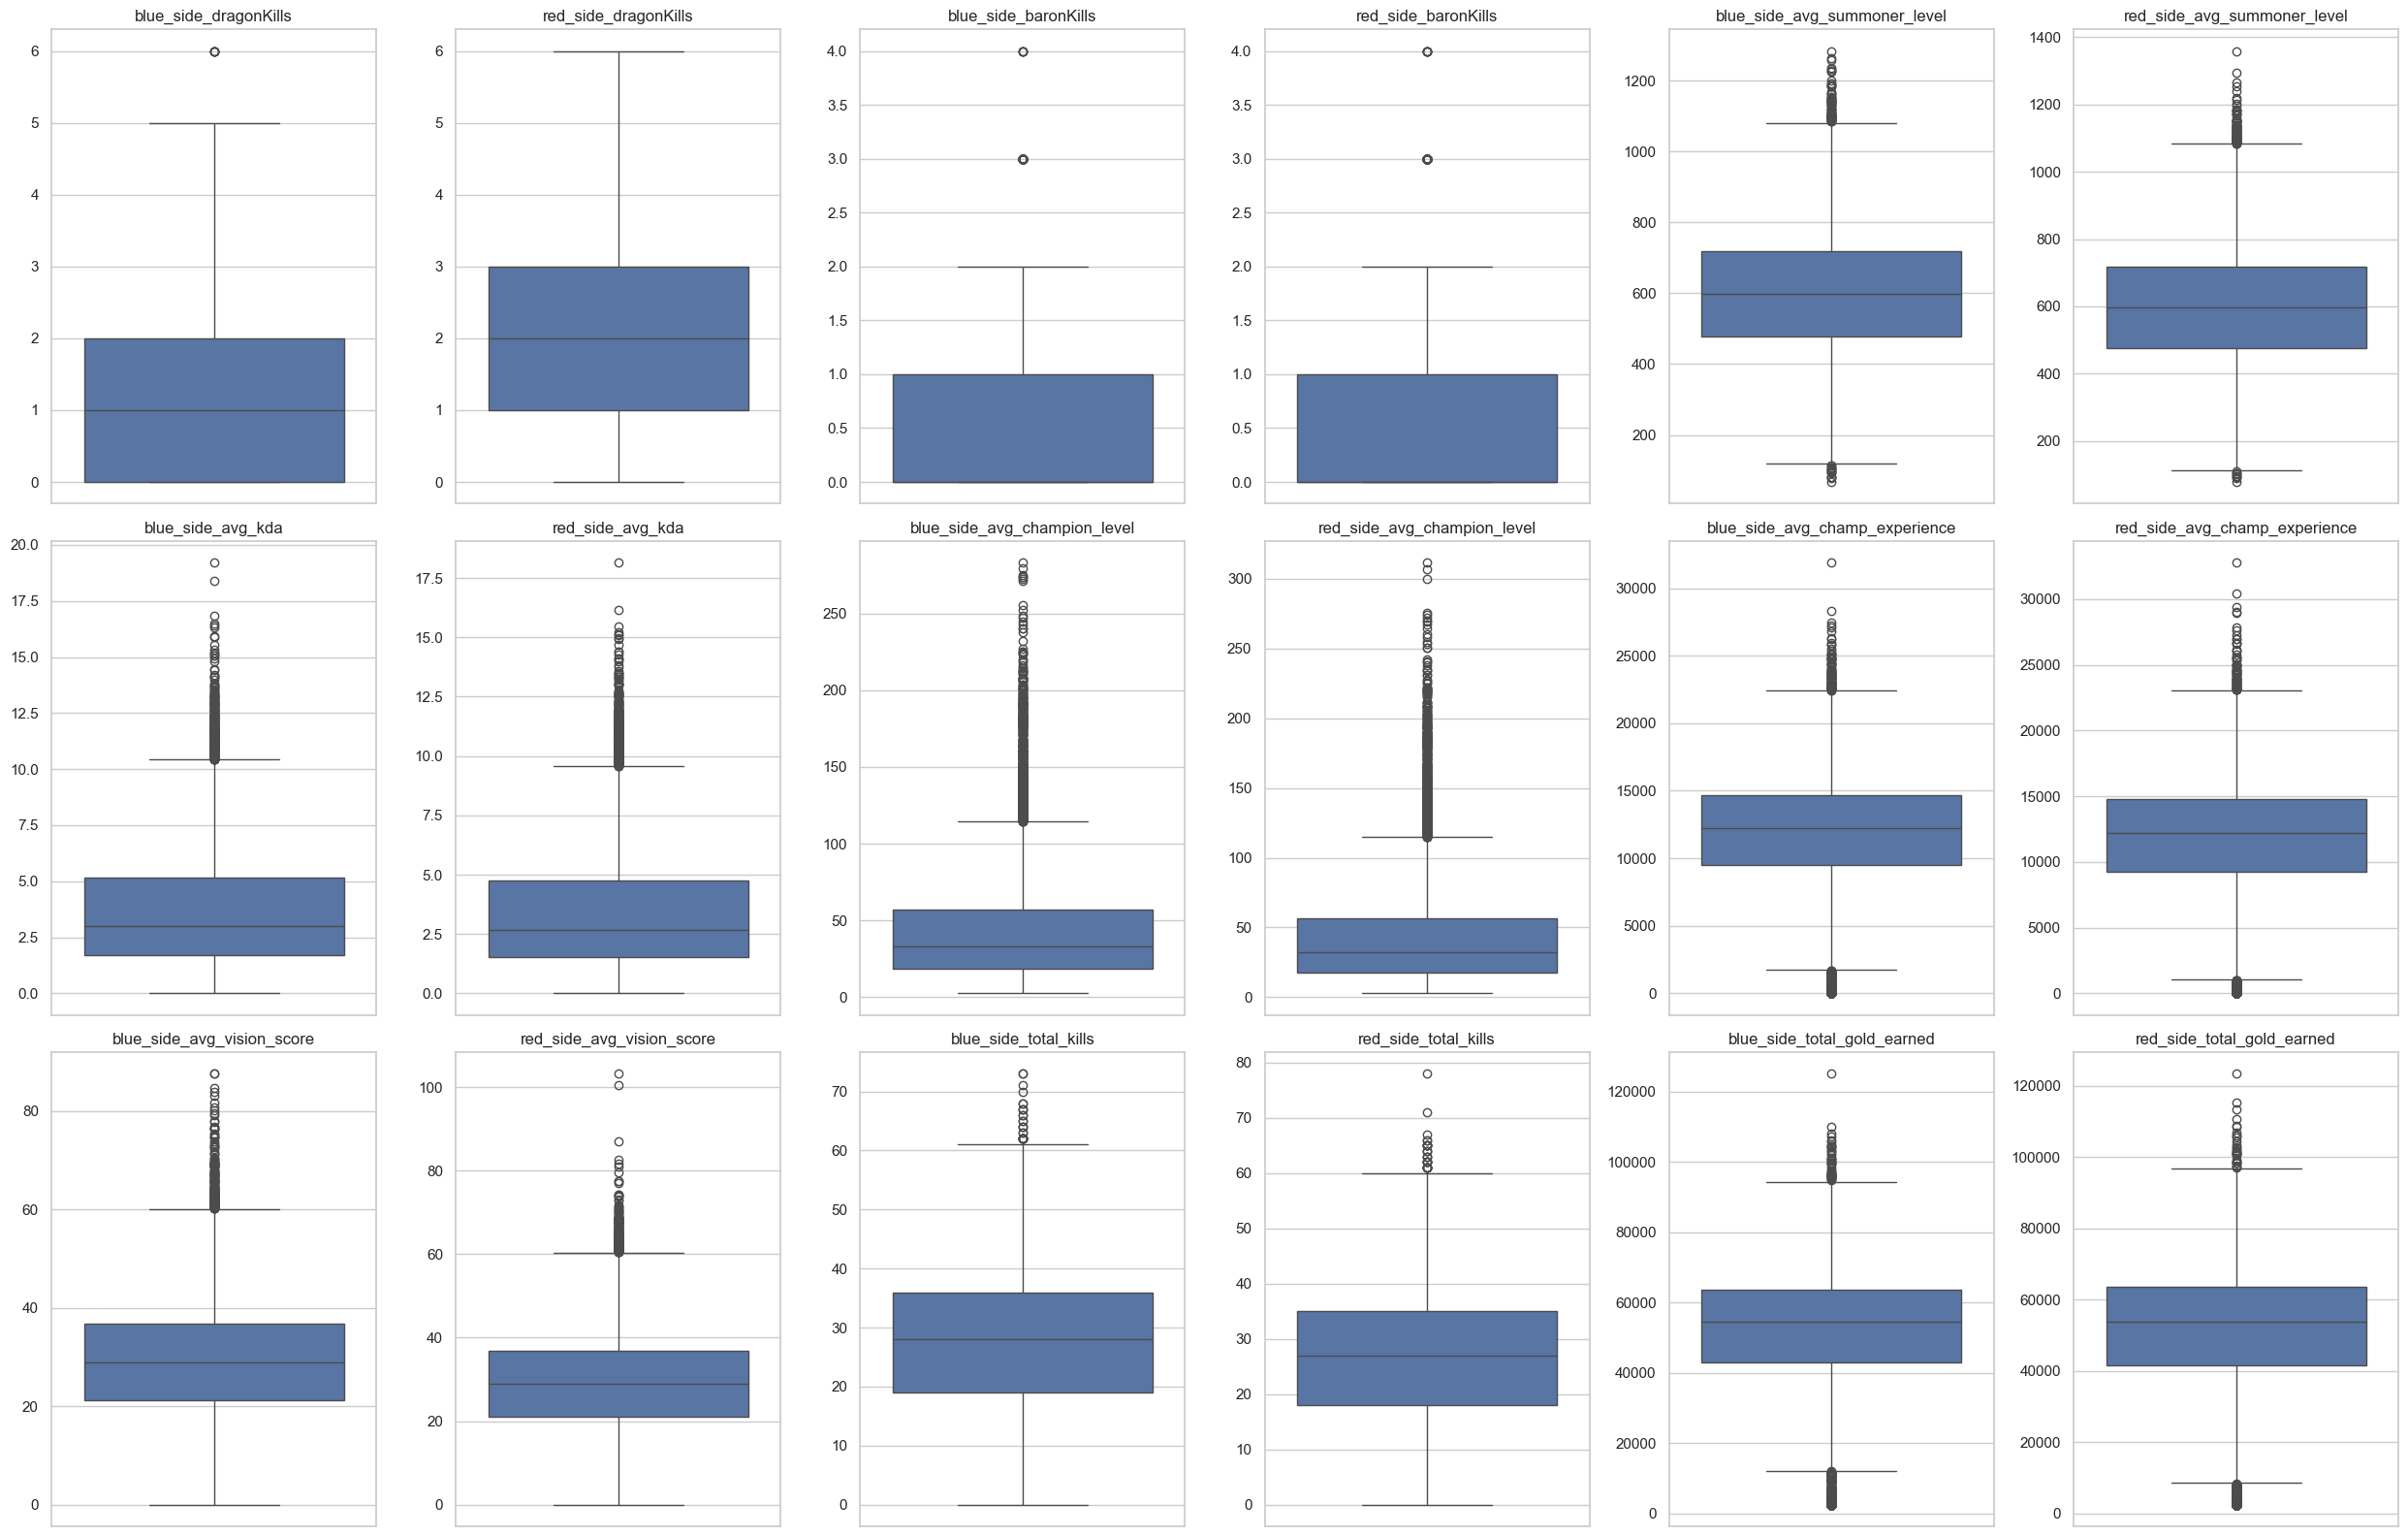

In [10]:
data_num = data[['blue_side_dragonKills', 'red_side_dragonKills', 'blue_side_baronKills', 'red_side_baronKills', 'blue_side_avg_summoner_level', 'red_side_avg_summoner_level', 'blue_side_avg_kda', 'red_side_avg_kda', 'blue_side_avg_champion_level', 'red_side_avg_champion_level', 'blue_side_avg_champ_experience', 'red_side_avg_champ_experience', 'blue_side_avg_vision_score', 'red_side_avg_vision_score', 'blue_side_total_kills', 'red_side_total_kills', 'blue_side_total_gold_earned', 'red_side_total_gold_earned']]

num_cols = 6
num_rows = (len(data_num.columns) // num_cols) + (1 if len(data_num.columns) % num_cols > 0 else 0)

plt.figure(figsize=(25, 16))
for i, col in enumerate(data_num.columns):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=data_num[col])
    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

#### Proporção de Vitórias

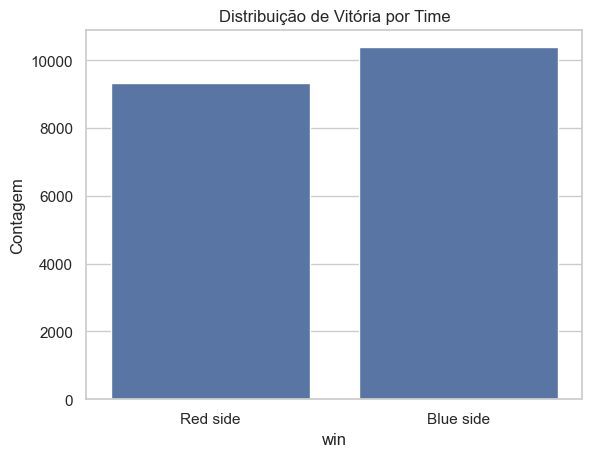

In [11]:
sns.countplot(x='win', data=data)
plt.title('Distribuição de Vitória por Time')
plt.xticks([0, 1], ['Red side', 'Blue side'])
plt.ylabel('Contagem')
plt.show()

#### Top 5 campeões mais jogados por posição e lado

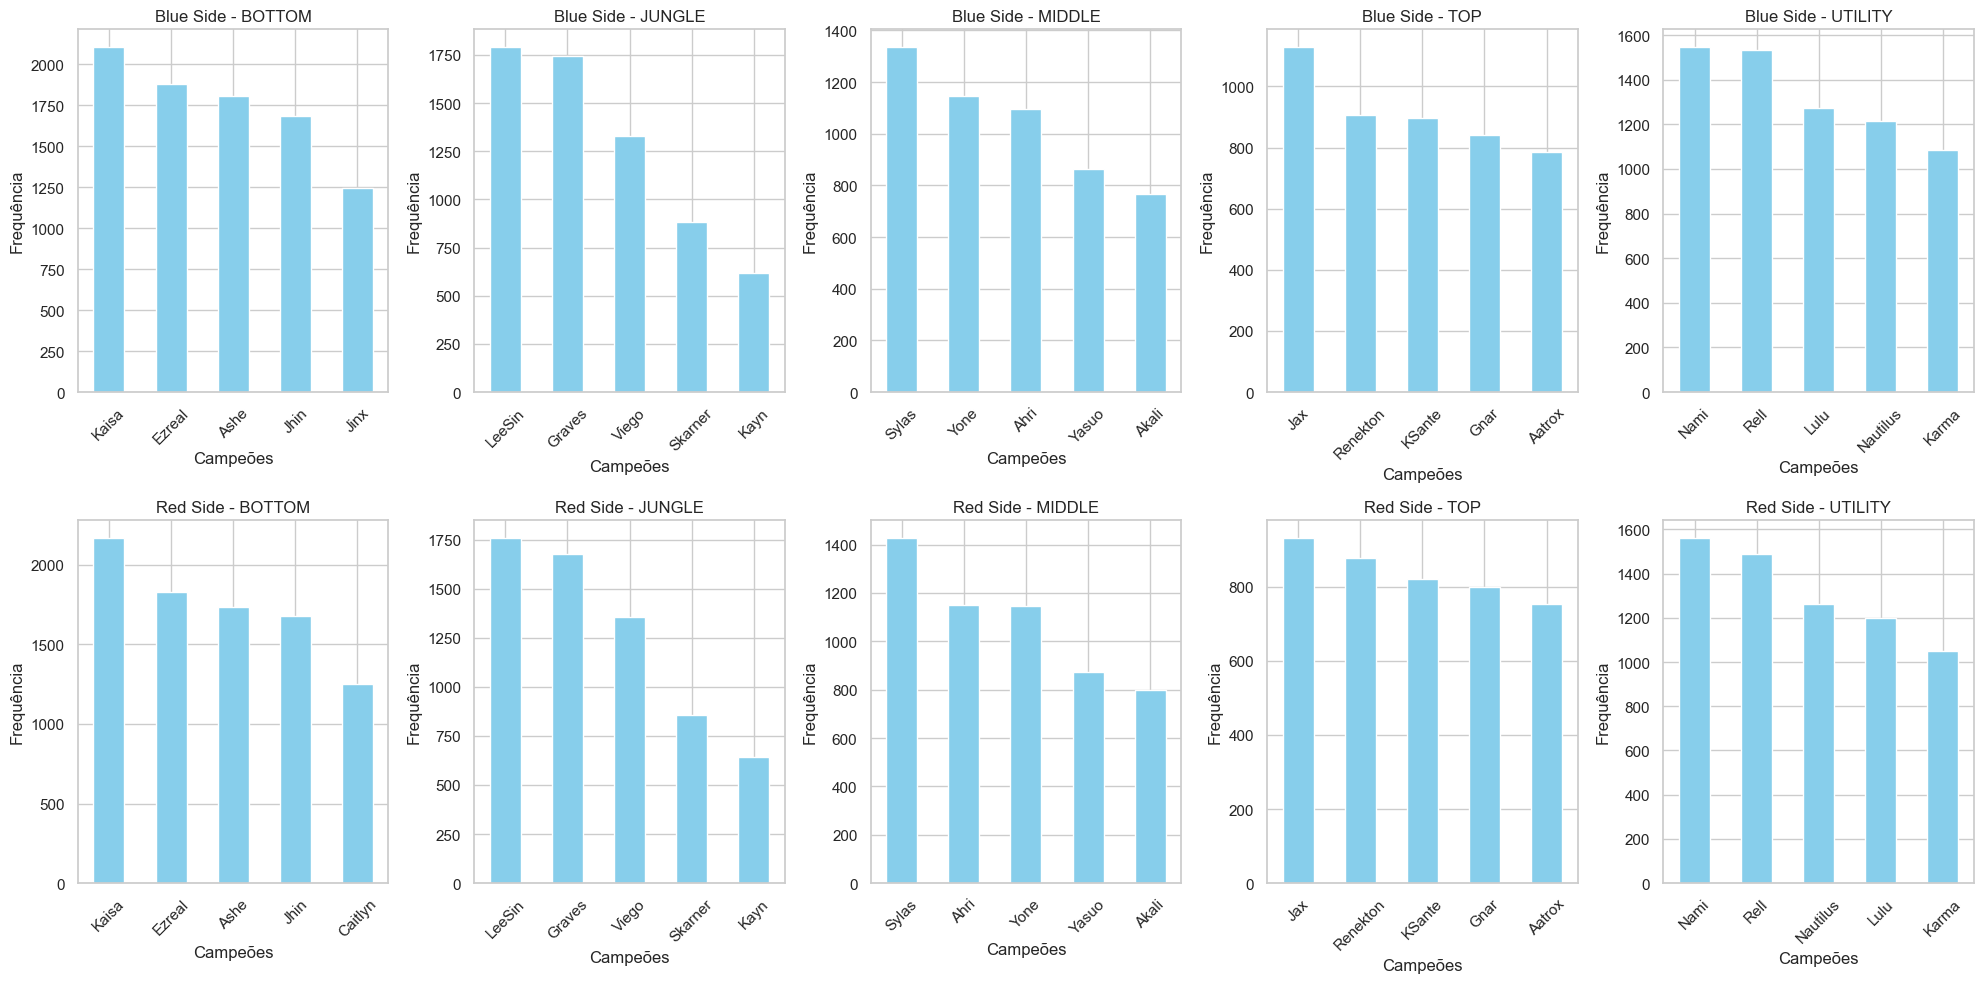

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten() 

lane_columns = [col for col in data.columns if col.startswith('100_') or col.startswith('200_')]

for i, col in enumerate(lane_columns):
    freq = data[col].value_counts()
    top_freq = freq.head(5)

    side = "Blue Side" if col.startswith("100_") else "Red Side"
    lane = col.split('_')[1] 
    title = f'{side} - {lane}'
    
    ax = axes[i]
    top_freq.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Campeões')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Análise Bivariada

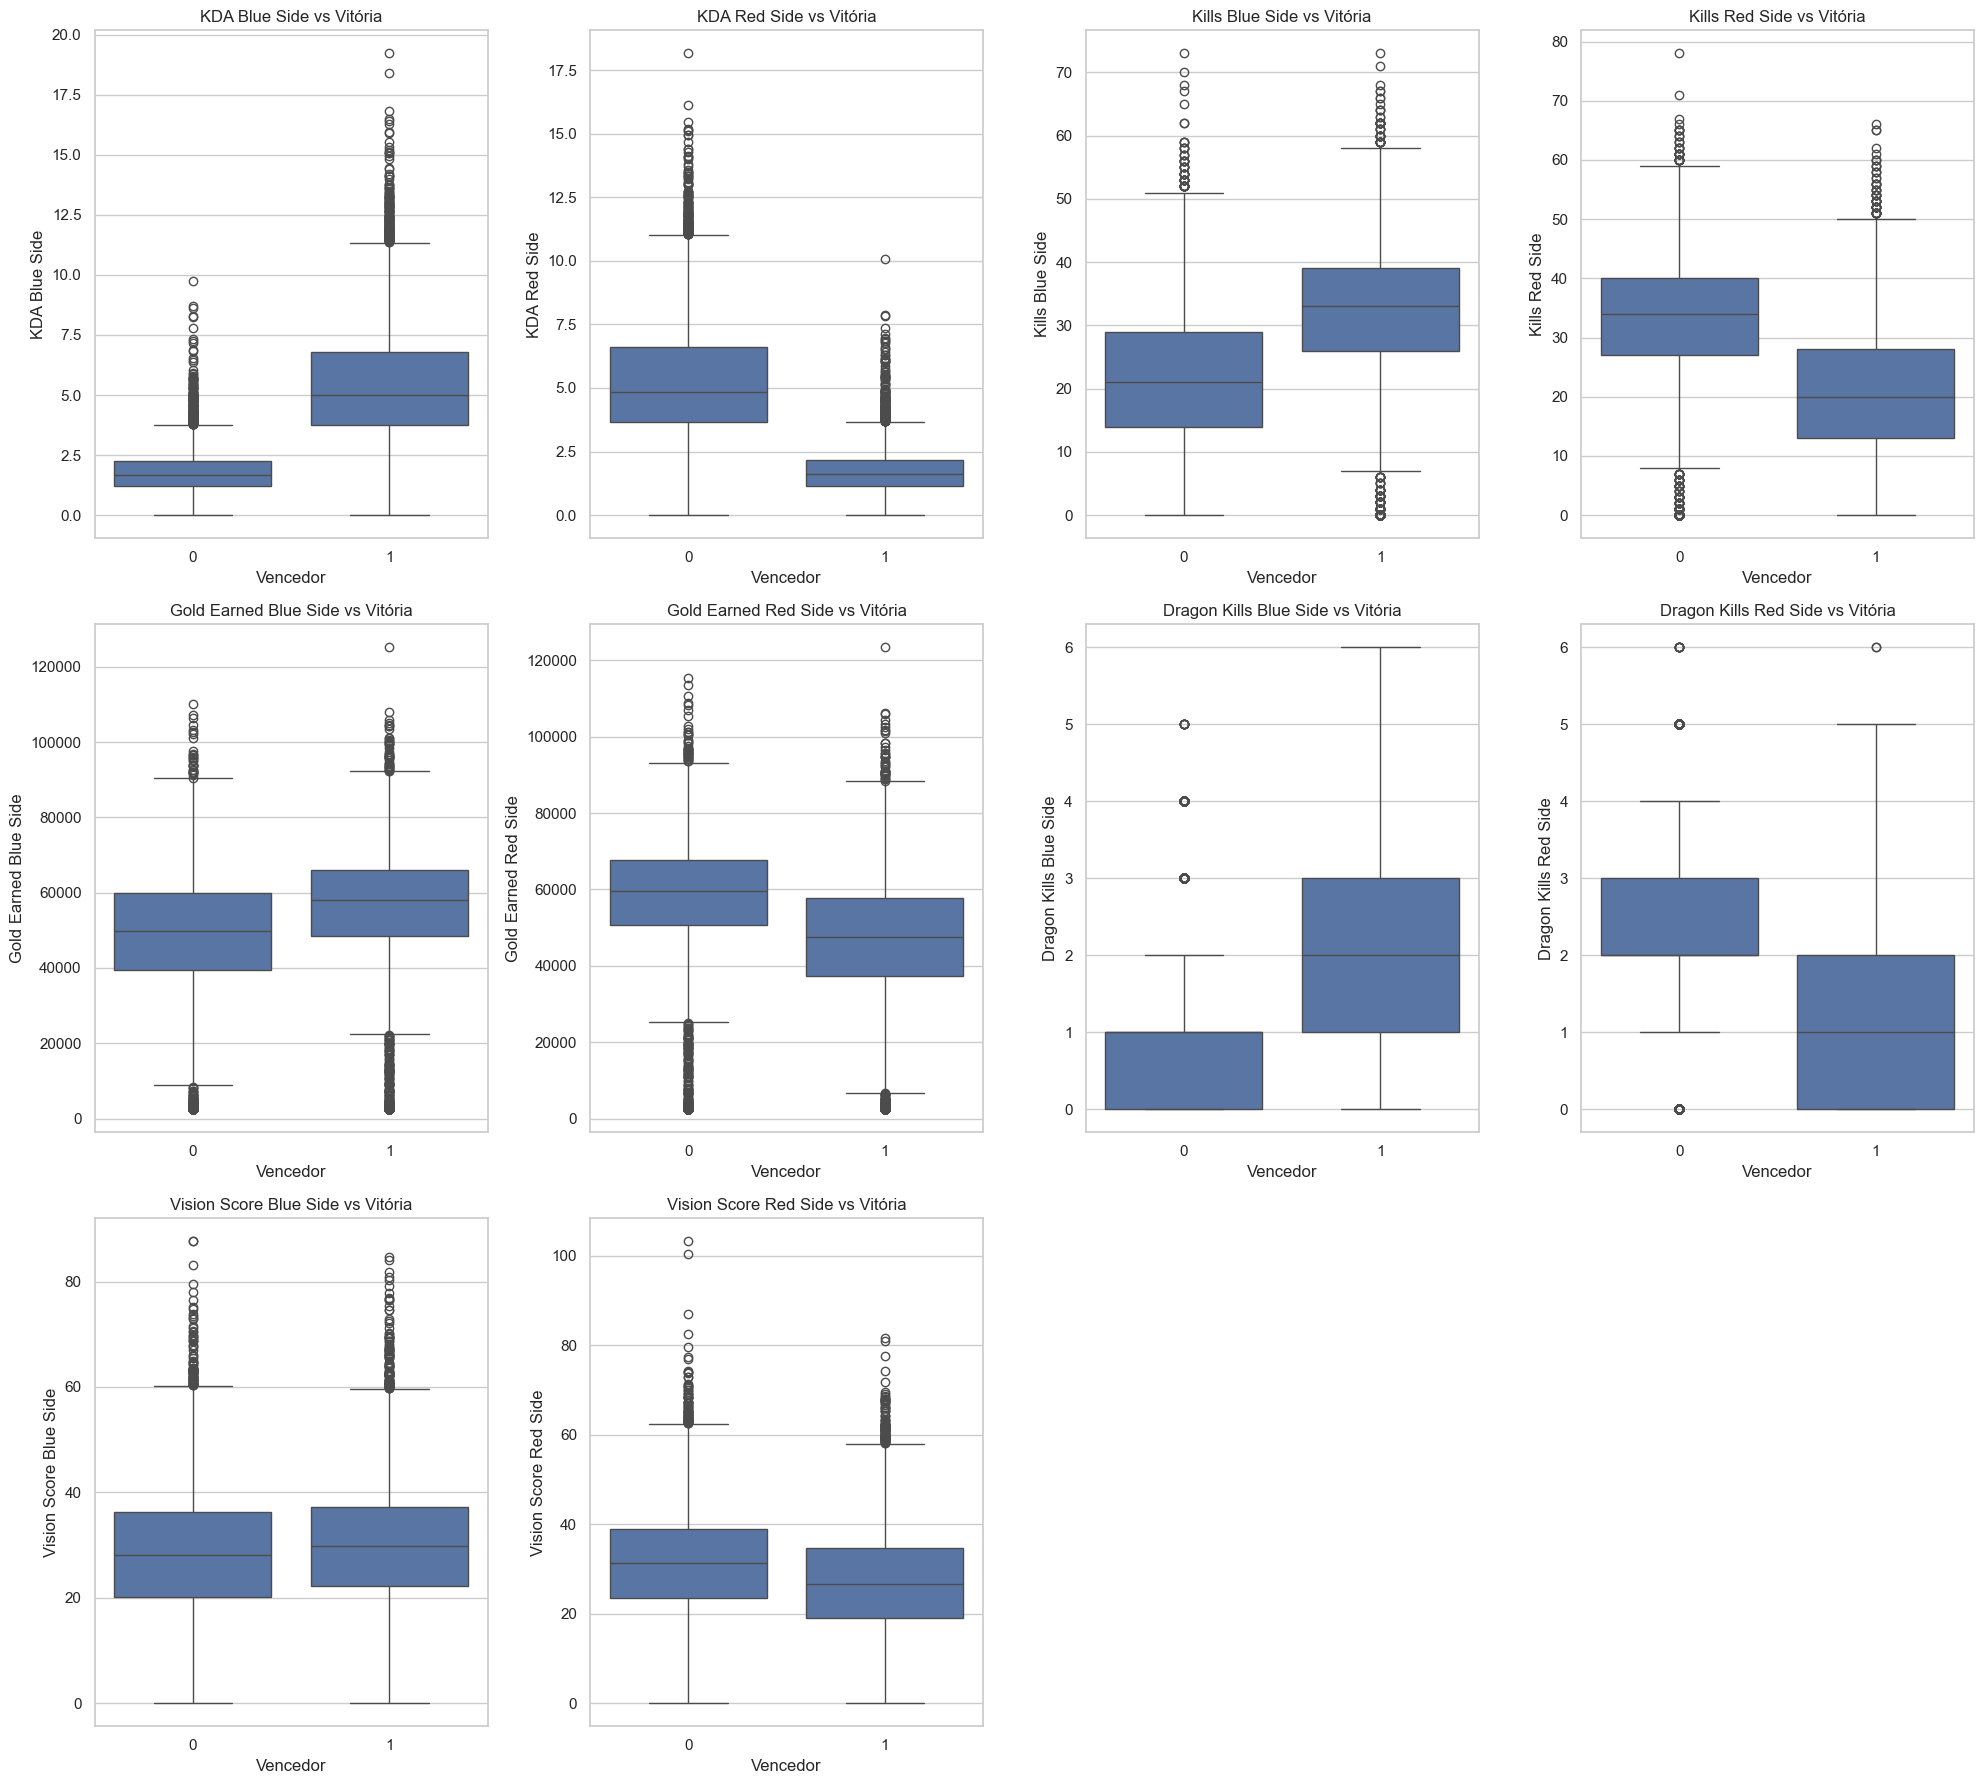

In [13]:
numerical_variables = [
    'blue_side_avg_kda', 'red_side_avg_kda', 
    'blue_side_total_kills', 'red_side_total_kills', 
    'blue_side_total_gold_earned', 'red_side_total_gold_earned',
    'blue_side_dragonKills', 'red_side_dragonKills',
    'blue_side_avg_vision_score', 'red_side_avg_vision_score'
]

y_label = ['KDA Blue Side', 'KDA Red Side', 
           'Kills Blue Side', 'Kills Red Side', 
           'Gold Earned Blue Side', 'Gold Earned Red Side',
           'Dragon Kills Blue Side', 'Dragon Kills Red Side',
           'Vision Score Blue Side', 'Vision Score Red Side']

plt.figure(figsize=(20, 18))

for i, col in enumerate(numerical_variables):
    plt.subplot(3, 4, i+1)
    sns.boxplot(data=data, x='win', y=col)
    plt.xlabel('Vencedor')
    plt.ylabel(y_label[i])
    plt.title(f'{y_label[i]} vs Vitória')

plt.tight_layout()
plt.show()


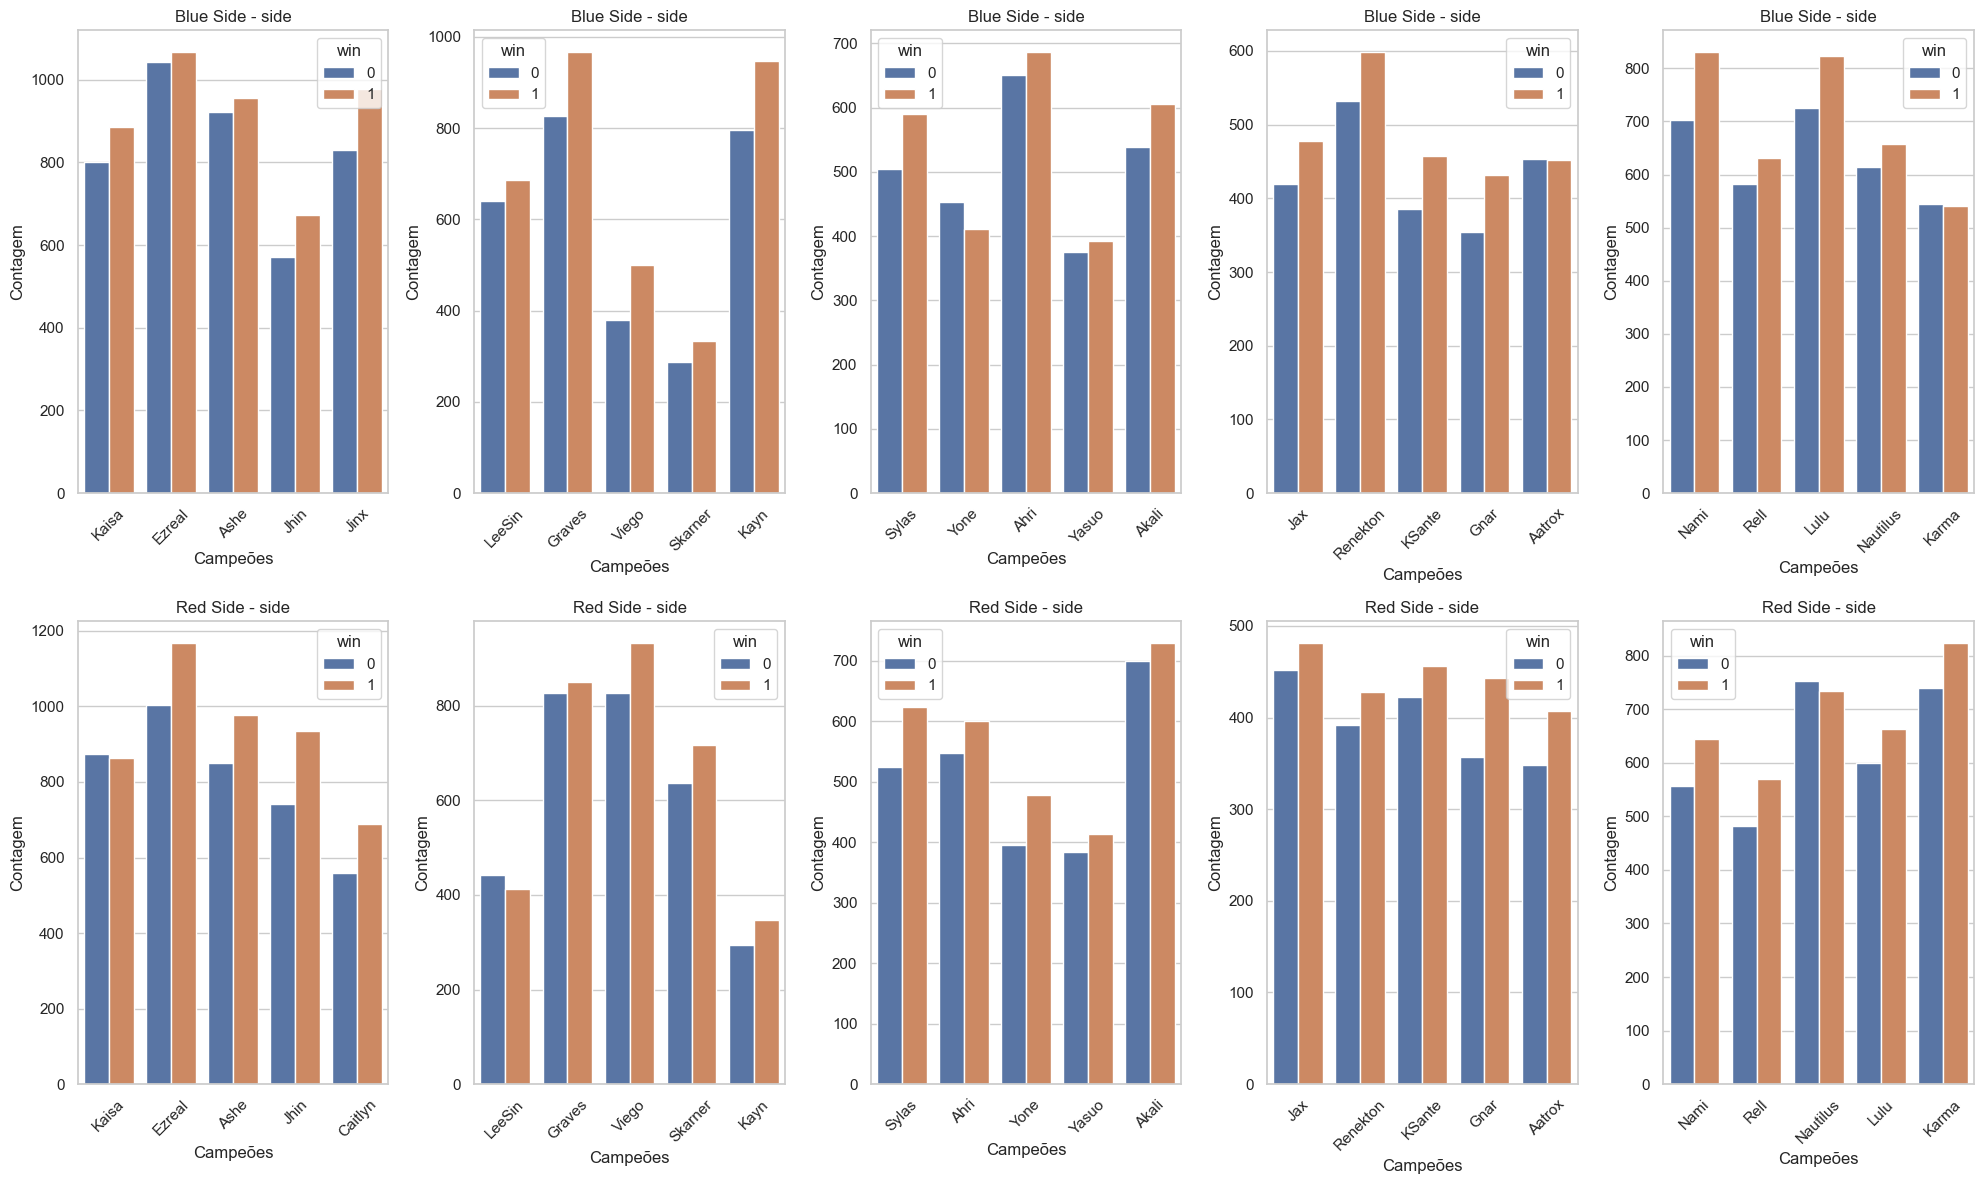

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

for i, lane in enumerate(lane_columns):
    top_champions = data[lane].value_counts().nlargest(5).index
    sns.countplot(x=lane, data=data[data[lane].isin(top_champions)], hue='win', ax=axes[i])
    
    side = "Blue Side" if lane.startswith("100_") else "Red Side"
    lane = col.split('_')[1]
    title = f'{side} - {lane}'
    
    axes[i].set_title(title)
    
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(top_champions, rotation=45)
    axes[i].set_ylabel('Contagem')
    axes[i].set_xlabel('Campeões')
    
plt.tight_layout()
plt.show()


# Modelagem

#### Separação das bases

In [15]:
data['gameStartDate'] = pd.to_datetime(data['gameStartDate']).dt.date

data_train = data[data['gameStartDate'] < date(2024,12,1)]
data_validation = data[data['gameStartDate'] > date(2024,12,1)]

#### Pré-processamento e Modelos 

In [16]:
drop_columns = ['matchId', 'participants', 'endOfGameResult', 'gameStartTimestamp', 'gameStartDate', 'win']

X_validation = data_validation.drop(columns = drop_columns)
y_validation = data_validation['win']

X = data.drop(columns = drop_columns) 
y = data['win']

X_sample = X
y_sample = y

In [17]:
pre_processamento = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

In [18]:
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
        'min_samples_leaf': [10, 20, 50, 100],
        'max_depth': [2, 3, 5, 10]
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5]
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [10, 20, 50, 100]
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0, 0.1, 0.5, 1]
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'max_depth': [2, 3, 5, 10],
        'min_data_in_leaf': [10, 20, 50, 100]
    })
}

In [19]:
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [ ]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # Escolha entre grid search ou random search. No random search, altere a métrica que deseja otimizar em 'refit' e a quantidade de iterações, se for necessário
  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LOGÍSTICA ---
Média de AUC: 0.997
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.973
D.P. de Acurácia Balanceada: 0.003
Média de Sensibilidade: 0.977
D.P. de Sensibilidade: 0.003

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.985
D.P. de AUC: 0.001
Média de Acurácia Balanceada: 0.934
D.P. de Acurácia Balanceada: 0.005
Média de Sensibilidade: 0.935
D.P. de Sensibilidade: 0.013



#### Ajuste do Modelo

In [ ]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

#### Importância das Features

In [ ]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [ ]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [1]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(modelo_final.best_estimator_)
valores_shap = explainer(X_sample_transformed)

# Gráfico do SHAP absoluto médio por feature
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.plots.bar(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

NameError: name 'shap' is not defined

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.summary_plot(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

#### Aplicação do Modelo

In [ ]:
X_transformed = pre_processamento.fit_transform(X_validation)
X_sample_transformed = X_transformed[X_sample.index]

y_prob = modelo_final.best_estimator_.predict_proba(X_transformed)[:,1]
ponto_corte = y_sample.astype(int).mean()
data_validation['y_pred'] = (y_prob >= ponto_corte).astype(int)

In [ ]:
pd.crosstab(y_validation, data_validation['y_pred'])